# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

- Nama: Nicolas Debrito
- Email: nicolas.debrito66@gmail.com
- ID Dicoding: reezzy

## Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from warnings import filterwarnings
filterwarnings('ignore')

## Download and Extract Dataset

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d muamkh/ihsgstockdata

Dataset URL: https://www.kaggle.com/datasets/muamkh/ihsgstockdata
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
ihsgstockdata.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
with zipfile.ZipFile('ihsgstockdata.zip', 'r') as zip_ref:
    zip_ref.extractall('ihsgstockdata')

## Preprocessing Data

Mengambil 18900 data dari 1 Nov 2021 - 31 Des 2021 (dua bulan)

In [12]:
df = pd.read_csv('ihsgstockdata/minutes/BBCA.csv')
df = df.head(18900)
df

,timestamp,open,low,high,close,volume
0,2021-11-01 09:00:00,7550,7500,7550,7525,881000
1,2021-11-01 09:01:00,7525,7475,7525,7500,652500
2,2021-11-01 09:02:00,7500,7475,7500,7500,55900
3,2021-11-01 09:03:00,7500,7475,7500,7500,250800
4,2021-11-01 09:04:00,7500,7450,7500,7475,796400
...,...,...,...,...,...,...
18895,2021-12-31 15:55:00,7300,7300,7300,7300,0
18896,2021-12-31 15:56:00,7300,7300,7300,7300,0
18897,2021-12-31 15:57:00,7300,7300,7300,7300,0
18898,2021-12-31 15:58:00,7300,7300,7300,7300,0


Harga diambil dari harga saat sekuritas finansial dibuka di pasar saat perdagangan dimulai.

Text(0.5, 1.0, 'BBCA Stock Price')

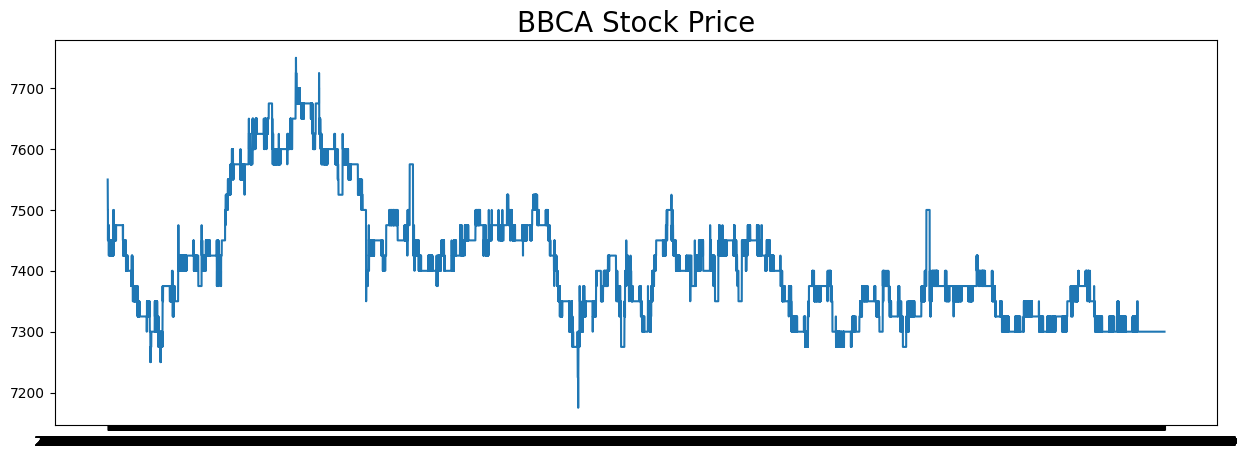

In [13]:
dates = df['timestamp'].values
price = df['open'].values

plt.figure(figsize=(15, 5))
plt.plot(dates, price)
plt.title('BBCA Stock Price', fontsize=20)

In [14]:
shape = price.shape
scaler = StandardScaler()
scaled_price = scaler.fit_transform(price.reshape(-1, 1))
scaled_price = scaled_price.reshape(shape)
scaled_price

array([ 1.45446101,  1.19290962,  0.93135822, ..., -1.16105293,
       -1.16105293, -1.16105293])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_price, dates, test_size=0.2, shuffle=False)

print(X_train.shape[0])
print(X_test.shape[0])

15120
3780


In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [17]:
train_set = windowed_dataset(X_train, window_size=30, batch_size=64, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=30, batch_size=64, shuffle_buffer=1000)

In [18]:
model = tf.keras.models.Sequential([
    LSTM(60, return_sequences=True),
    LSTM(60),
    Dense(30, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
            optimizer=optimizer,
            metrics=['mae'])

In [20]:
threshold_mae = (scaled_price.max() - scaled_price.min()) * 10/100
print(threshold_mae)

0.6015682065327239


In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
      print("\nNilai MAE < 10%")
      self.model.stop_training = True

callbacks = myCallback()

In [22]:
history = model.fit(train_set,
                    epochs=100,
                    validation_data = test_set,
                    callbacks=[callbacks])

Epoch 1/100
236/236 [==============================] - 35s 122ms/step - loss: 0.4186 - mae: 0.7727 - val_loss: 0.3466 - val_mae: 0.7753
Epoch 2/100
236/236 [==============================] - 16s 68ms/step - loss: 0.4016 - mae: 0.7500 - val_loss: 0.3313 - val_mae: 0.7562
Epoch 3/100
236/236 [==============================] - 16s 68ms/step - loss: 0.3902 - mae: 0.7352 - val_loss: 0.3205 - val_mae: 0.7421
Epoch 4/100
236/236 [==============================] - 20s 81ms/step - loss: 0.3810 - mae: 0.7231 - val_loss: 0.3097 - val_mae: 0.7279
Epoch 5/100
236/236 [==============================] - 21s 90ms/step - loss: 0.3726 - mae: 0.7119 - val_loss: 0.2987 - val_mae: 0.7133
Epoch 6/100
236/236 [==============================] - 17s 68ms/step - loss: 0.3648 - mae: 0.7013 - val_loss: 0.2877 - val_mae: 0.6985
Epoch 7/100
236/236 [==============================] - 18s 74ms/step - loss: 0.3579 - mae: 0.6915 - val_loss: 0.2767 - val_mae: 0.6835
Epoch 8/100
236/236 [==============================] -

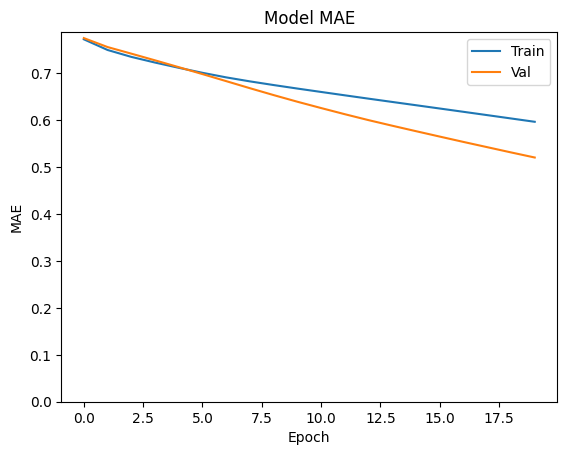

In [23]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(ymin=0)
plt.show()